# Abert Model Evals 

Raw models evaluation.

In [17]:
import os
import sys
import time

import dotenv
from IPython.display import HTML
import numpy as np
import pandas as pd
import requests

dotenv.load_dotenv("../.env")
sys.path.append("..")

#EVALAP_API_URL = "http://localhost:8000/v1"
EVALAP_API_URL = "https://evalap.etalab.gouv.fr/v1"
ALBERT_API_URL = "https://albert.api.etalab.gouv.fr/v1"
# keys
EVALAP_API_KEY = os.getenv("EVALAP_API_KEY") 
ALBERT_API_KEY = os.getenv("ALBERT_API_KEY")

headers = {"Authorization": f"Bearer {EVALAP_API_KEY}"}

In [9]:
# Design and run the experiments
# --
for dataset in ["MFS_questions_v01",  "Assistant IA - QA"]:
    expset_name = f"Albert - brut - ({dataset}) v1-10-25"
    expset_readme = f"Comparing raw Albert models on dataset {dataset}"
    metrics = ["judge_exactness", "judge_precision", "output_length", "generation_time"]
    common_params = {
        "dataset" : dataset,
        "model": {"sampling_params" : {"temperature": 0.2}},
        "metrics" : metrics,
        "judge_model": "gpt-4.1",
    }
    grid_params = {
        "model": [
            {"name": "meta-llama/Llama-3.1-8B-Instruct", "base_url": ALBERT_API_URL, "api_key": ALBERT_API_KEY},
            {"name": "mistralai/Mistral-Small-3.2-24B-Instruct-2506", "base_url": ALBERT_API_URL, "api_key": ALBERT_API_KEY},
            {"name": "Qwen/Qwen3-30B-A3B-Instruct-2507", "base_url": "http://51.15.199.237/v1", "api_key": "changeme"},
        ],
    }
    
    # Lauching the experiment set
    expset = {
        "name" : expset_name, 
        "readme": expset_readme,
        "cv": {"common_params": common_params, "grid_params": grid_params, "repeat":2}
    }
    response = requests.post(f'{EVALAP_API_URL}/experiment_set', json=expset, headers=headers)
    resp = response.json()
    if "id" in resp:
        expset_id = resp["id"]
        print(f'Created expset: {resp["name"]} ({resp["id"]})')
    else:
        print(resp)

Created expset: albert_mfs_questions_v01_v1-10-25 (73)
Created expset: albert_assistant_ia_-_qa_v1-10-25 (74)


In [13]:
# PATCH my experiments
# --
for dataset, expid in [("MFS_questions_v01",73),  ("Assistant IA - QA",74)]:
    expset_name = f"Albert ({dataset}) v1-10-25"
    expset_readme = f"Comparing Albert Models on dataset {dataset}"
    metrics = ["judge_exactness", "judge_precision", "output_length", "generation_time"]
    common_params = {
        "dataset" : dataset,
        #"model": {"sampling_params" : {"temperature": 0.2}},
        "metrics" : metrics,
        "judge_model": "gpt-4.1",
    }
    grid_params = {
        "model": [
            #{"name":"gpt-5", "base_url":"https://api.openai.com/v1", "api_key":os.getenv("OPENAI_API_KEY")}
            {"name": "mistralai/Magistral-Small-2506", "base_url": "http://51.15.199.237/v1", "api_key": "changeme"},

        ],
    }
    
    # Lauching the experiment set
    expset = {
        "name" : expset_name, 
        "readme": expset_readme,
        "cv": {"common_params": common_params, "grid_params": grid_params, "repeat":2}
    }
    response = requests.patch(f'{EVALAP_API_URL}/experiment_set/{expid}', json=expset, headers=headers)
    resp = response.json()
    if "id" in resp:
        expset_id = resp["id"]
        print(f'Patched expset: {resp["name"]} ({resp["id"]})')
    else:
        print(resp)

Patched expset: Albert (MFS_questions_v01) v1-10-25 <3 (73)
Patched expset: Albert (Assistant IA - QA) v1-10-25 <3 (74)


## Reading and showing results

-> Show the mean and std score, for each metrics, across the experiment repetition. The std show the variability of the model.

In [7]:
# Various utility functions
# --
def format_metrics(row):
   # format a dataframe has a series of "mean ± std"
   metrics = {}
   for metric in final_df.columns.levels[0]:
       mean_value = row[(metric, 'mean')]
       std_value = row[(metric, 'std')]
       metrics[metric] = f"{mean_value:.2f} ± {std_value:.2f}"
   return pd.Series(metrics)
    
def highlight_cells(s):
 # Custom function to highlight the entry with the highest/lowest mean value
    means = s.apply(lambda x: float(x.split('±')[0].strip()))
    # Create a mask where 1 for max, 0 for min
    max_mean_index = means.idxmax()
    min_mean_index = means.idxmin()  
    mask = pd.Series({max_mean_index: 1, min_mean_index: 0}, index=s.index)
    return [
        'font-weight: bold; color: salmon' if mask_value == 0 else
        'font-weight: bold; color: green' if mask_value == 1 else
        ''
        for mask_value in mask
    ]

In [8]:
# Read results
# --
df_all = None # multi-dimensional DataFrame
arr_all = {} # keep references of source array per metric metrics 

# Fetch results and compute macro metrics (mean, std etc).
# --
response = requests.get(f'{EVALAP_API_URL}/experiment_set/{expset_id}', headers=headers)
expset = response.json()
rows = []
for i, exp in enumerate(expset["experiments"]):
    # Get an experiment result
    exp_id = exp["id"]
    response = requests.get(f'{EVALAP_API_URL}/experiment/{exp_id}?with_results=true', headers=headers)
    experiment = response.json()
    # experiment["name"] # Name of the experiment
    if experiment["experiment_status"] != "finished":
        print(f"Warning: experiment {exp_id} is not finished yet...")
    results = experiment["results"]
    model = experiment["model"]["name"]
    if experiment["model"].get("extra_params"):
        if experiment["model"]["extra_params"].get("rag") :
            model = experiment["model"]['name'] + "--rag"
    
    # Add an observation row from the observation_table (mean, std etc)
    row = {"model": model}
    rows.append(row)
    metric_arrs = {}
    arr_all[model] = metric_arrs
    for metric_results in results: 
        metric = metric_results["metric_name"]
        arr = np.array([x["score"] for x in metric_results["observation_table"] if pd.notna(x["score"])])
        row[(metric, 'mean')] = np.mean(arr)
        row[(metric, 'std')] = np.std(arr)
        row[(metric, 'median')] = np.median(arr)
        row[(metric, 'mean_std')] = f"{arr.mean():.2f} ± {arr.std():.2f}"  # Formatting as 'mean±std'
        row[(metric, 'support')] = len(arr)
        metric_arrs[metric] = arr
    
df_all = pd.DataFrame(rows)
df_all.set_index('model', inplace=True)
df_all.columns = pd.MultiIndex.from_tuples(df_all.columns)
final_df = df_all.xs('mean', axis=1, level=1) # pick the "macro" metric to show (mean, std, support etc)

# Group and average the result of the experiments by models
# --
final_df = final_df.groupby(level=0).agg(['mean', 'std'])  # groupby "model"
final_df.index.name = None
final_df = final_df.apply(format_metrics, axis=1) # final formating

#final_df = final_df.reindex([m["name"] for m in grid_params["model"]]) # reorder rows
final_df = final_df.sort_values(by='judge_exactness', ascending=False)
final_df = final_df[metrics] # reorder columns
final_df = final_df.style.apply(highlight_cells, axis=0)
final_df

,judge_exactness,judge_precision,output_length,generation_time
gpt-5,0.68 ± 0.02,0.67 ± 0.06,227.03 ± 7.42,46.79 ± 5.03
mistralai/Mistral-Small-3.2-24B-Instruct-2506,0.48 ± 0.00,0.47 ± 0.05,252.23 ± 4.44,11.72 ± 0.15
Qwen/Qwen3-30B-A3B-Instruct-2507,0.45 ± 0.05,0.43 ± 0.00,414.54 ± 13.47,11.12 ± 0.23
meta-llama/Llama-3.1-8B-Instruct,0.10 ± 0.02,0.08 ± 0.02,228.46 ± 4.21,6.52 ± 1.81


# Visualize the score dispersion for each metrics.

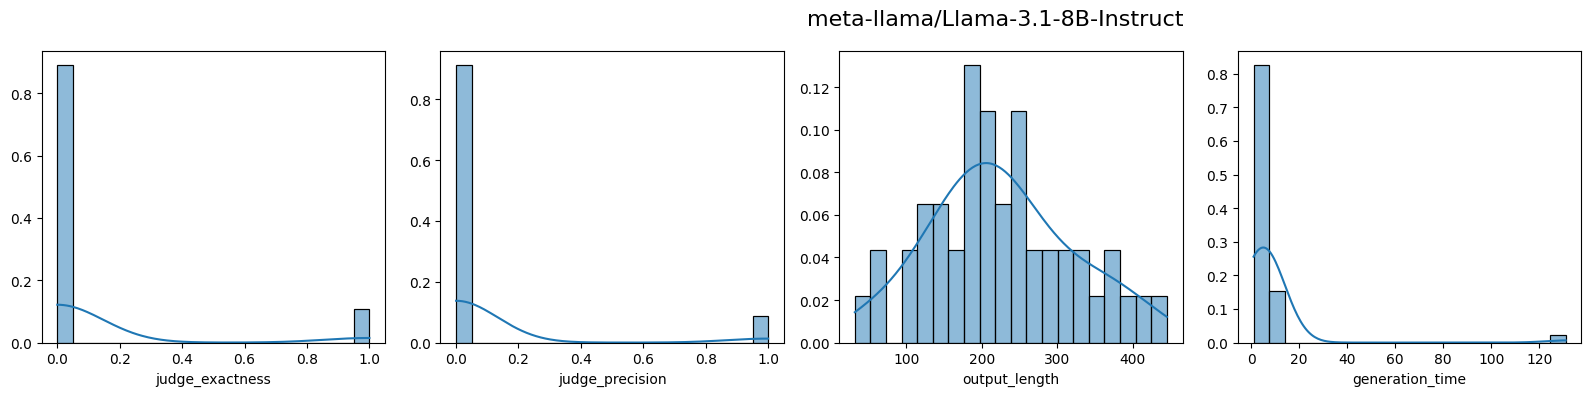

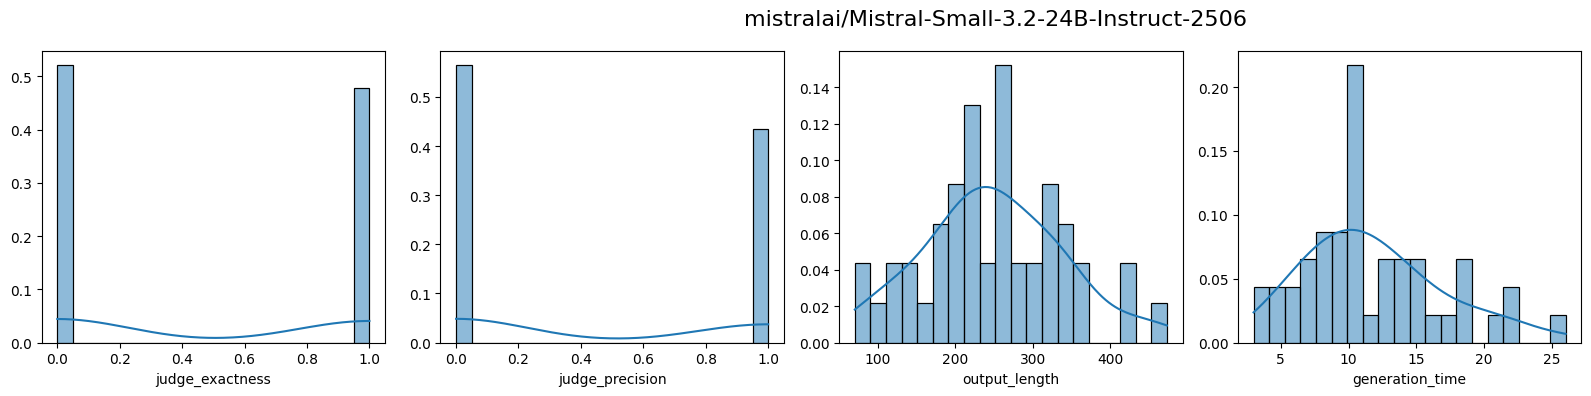

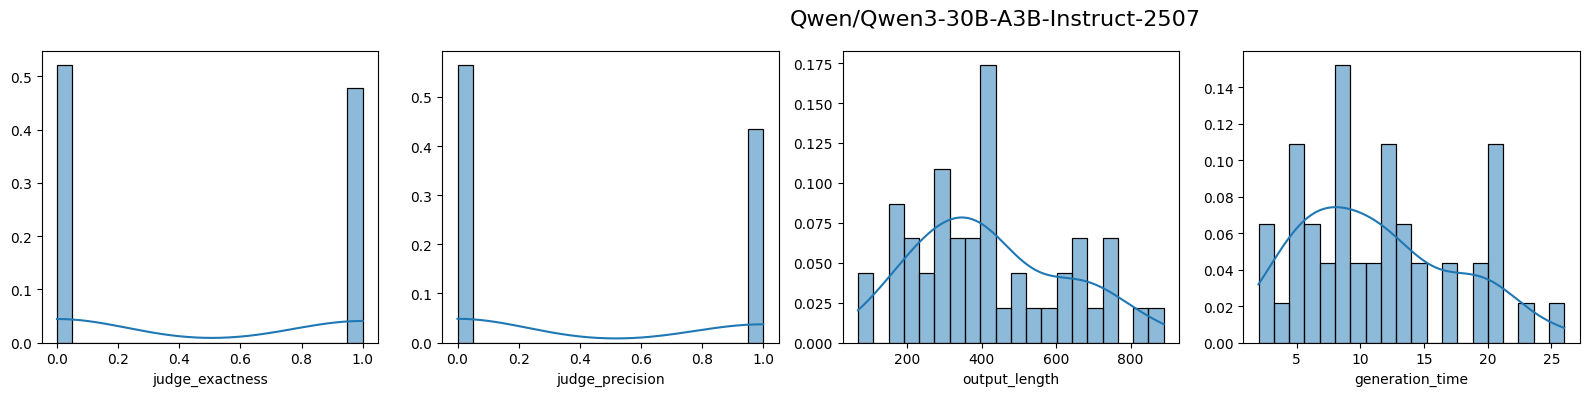

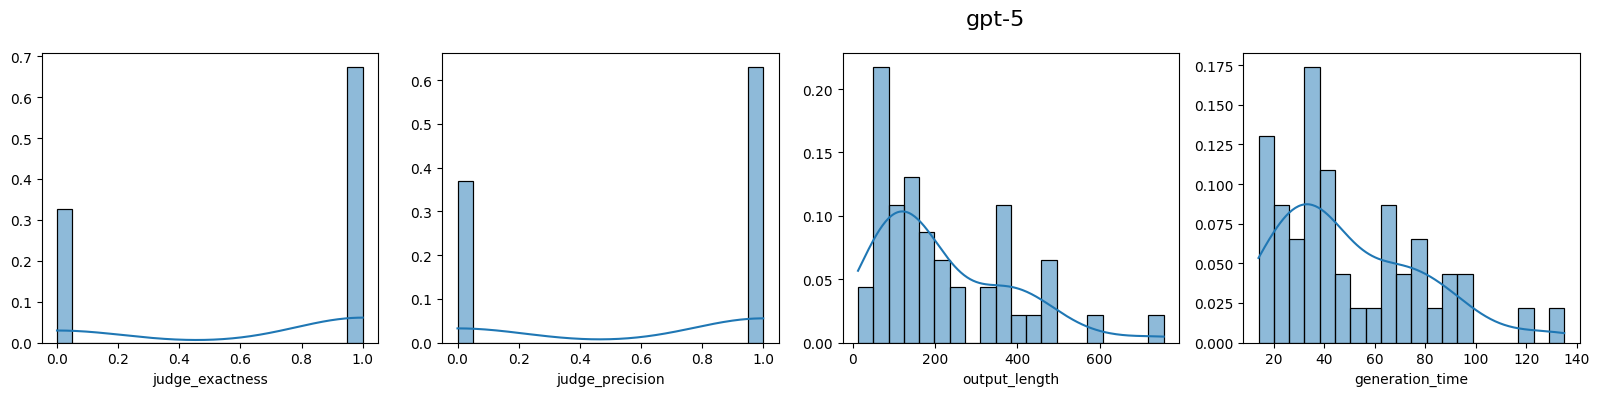

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

for model, metrics_arr in arr_all.items():
    experiment_title = model
    metrics_arr = {k:metrics_arr[k] for k in metrics} # reorder metrics
    # Pad missing value with np.nan
    arrays = list(metrics_arr.values())
    max_length = max(len(arr) for arr in arrays)
    arr_metrics = np.array([np.pad(arr, (0, max_length - len(arr)), constant_values=np.nan) for arr in arrays])    
    df = pd.DataFrame(arr_metrics.T, columns=metrics_arr.keys())
    
    num_cols = 5
    num_plots = len(df.columns)
    num_rows = (num_plots + num_cols - 1) // num_cols  
    plt.figure(figsize=(num_cols * 4, num_rows * 4))
    for i, column in enumerate(df.columns, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.histplot(df[column], bins=20, stat="probability", element="bars", kde=True)
        plt.ylabel("") 
    
    plt.suptitle(experiment_title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [9]:
# RETRY failed experiment !
# --
response = requests.post(f'{EVALAP_API_URL}/retry/experiment_set/{expset_id}', headers=headers)
response.json()

{'experiment_ids': [], 'result_ids': []}